In [1]:
import sys
import os


sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("NonHermitianQW"))))

In [2]:
from operators import op
from oneDimQW import *
from twoDimQW import *
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from berry import BerryPhase
from sympy import *
from ploting import berry_bloch_phase

In [3]:
import ipywidgets as widgets
from ipywidgets import interact

<h1>Two dimensional Quantum Walk</h1>

In [4]:
dim_x = 25
dim_y = 25

x_coin_dict = {
    "th" : pi/4,
    "n" : [0,1,0]
}
y_coin_dict = {
    "th" : pi/10,
    "n" : [0,1,0]
}
init_state = {
    "a" : 1,
    "b" : 0
}

steps = 100

model = single_coin_two_dim_QW(dim_x,dim_y,x_coin_dict,y_coin_dict,**init_state)
data_ = model.evolve(steps)
t,m,n = data_.shape

print(data_.shape)

(101, 25, 25)


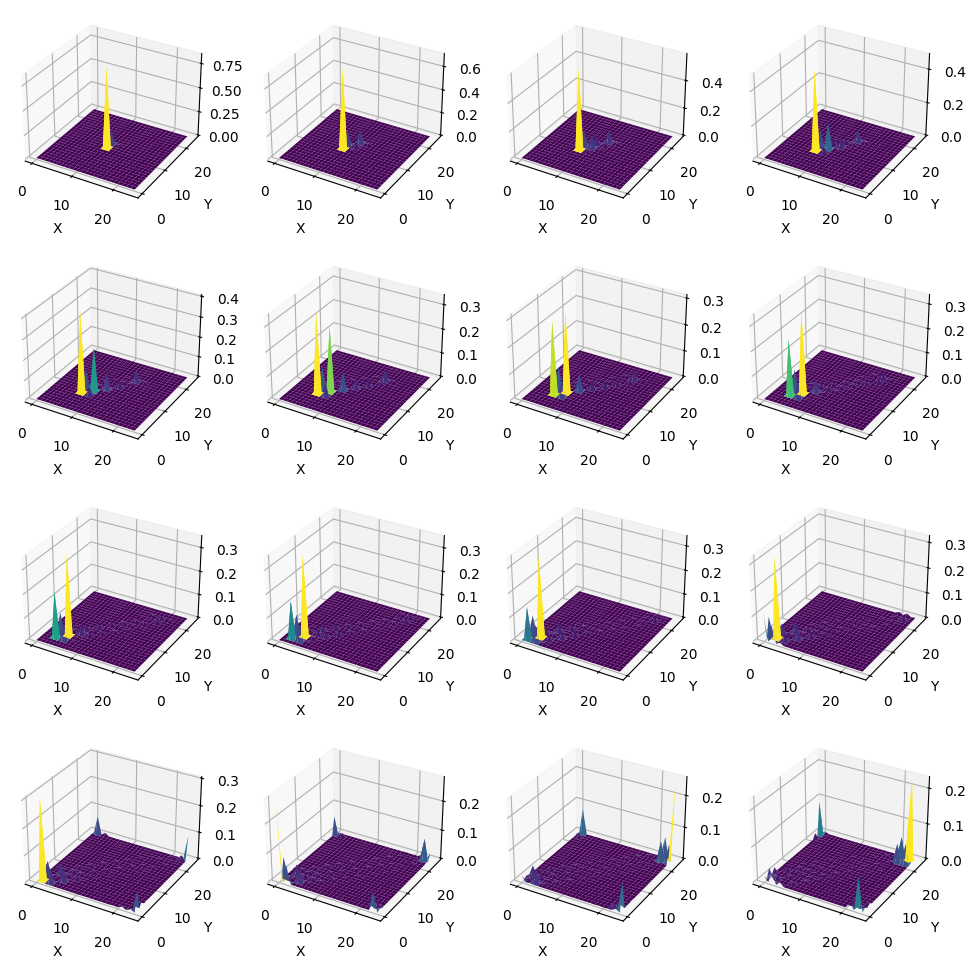

In [5]:
fig = plt.figure(figsize = (12,12))

X_,Y_ = np.meshgrid(np.arange(dim_x),np.arange(dim_y))

for i in range(1,17):
    axs = fig.add_subplot(4,4,i,projection='3d')
    axs.plot_surface(X_,Y_,data_[i],cmap='viridis')
    axs.set_xlabel("X")
    axs.set_ylabel("Y")

In [6]:
dim_x = 40
dim_y = 40

x_coin_dict = {
    "th" : pi/2,
    "n" : [0,1,0]
}
y_coin_dict = {
    "th" : pi/2,
    "n" : [0,1,0]
}
init_state = {
    "ax" : 1,
    "bx" : 0,
    "ay" : 1,
    "by" : 0
}

steps = 100

model = double_coin_two_dim_QW(dim_x,dim_y,x_coin_dict,y_coin_dict,**init_state)
data_ = model.Evolve(steps)


print(data_.shape)

(101, 40, 40)


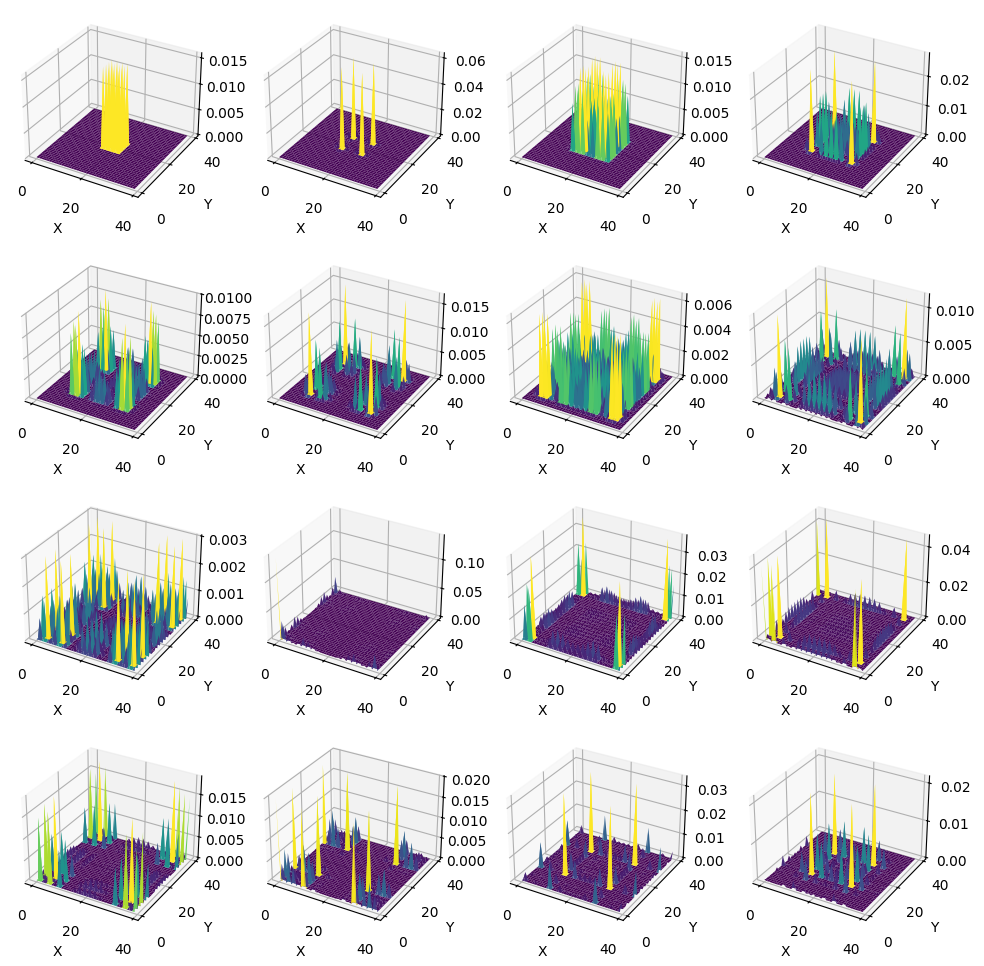

In [7]:
fig = plt.figure(figsize = (12,12))

X_,Y_ = np.meshgrid(np.arange(dim_x),np.arange(dim_y))

for i in range(1,17):
    axs = fig.add_subplot(4,4,i,projection='3d')
    axs.plot_surface(X_,Y_,data_[i*3],cmap='viridis')
    axs.set_xlabel("X")
    axs.set_ylabel("Y")

In [8]:
fig = plt.figure(figsize = (12,12))

X_,Y_ = np.meshgrid(np.arange(dim_x),np.arange(dim_y))

def vis(t_):
    axs = plt.subplot(111,projection="3d")
    axs.plot_surface(X_,Y_,data_[int(t_)],cmap='viridis')
    axs.set_xlabel("X")
    axs.set_ylabel("Y")
    axs.set_zlim(0,0.1)
    plt.show()

steps_slider = widgets.FloatSlider(value=1, min=0, max=100, step=1, description='steps')

interact(vis, t_ = steps_slider)

<Figure size 1200x1200 with 0 Axes>

interactive(children=(FloatSlider(value=1.0, description='steps', step=1.0), Output()), _dom_classes=('widget-…

<function __main__.vis(t_)>

IndexError: list index out of range

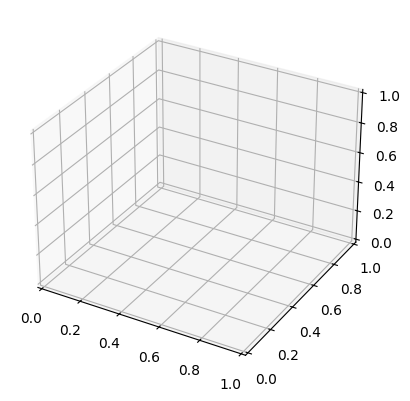

In [9]:
U_k = model.U_k
E_,_ = eig(U_k)
bands = [E_[i::4].reshape(dim_x,dim_y) for i in range(4)]

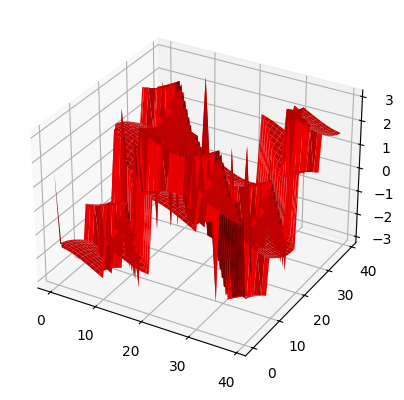

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X_,Y_,np.angle(bands[0]),color="red")
plt.show()